In [1]:
import os


base_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Croping"

In [2]:
import neurokit2 as nk
from nptdms import TdmsFile

patient_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"

# Import the TDMS file
tdms_file = TdmsFile.read(patient_path)
data = tdms_file.as_dataframe()
print(data.head())

column_name = data.columns[0]
print("Column name:", column_name)

   /'Untitled'/'EKG'
0         -70.270817
1          -1.377859
2          37.202197
3         -45.469352
4        -144.675212
Column name: /'Untitled'/'EKG'


In [3]:
# Extract first 5,000,000 samples into a new DataFrame (and keep a Series view if needed)
data_first_5M = data.iloc[:5_000_000].copy()
ecg_first_5M = data_first_5M[column_name]  # Series of the EKG channel for the first 5M samples

# # Optional: save to disk for later use (efficient binary format)
# output_path = os.path.join(base_path, "Patient5_first_5M.parquet")
# data_first_5M.to_parquet(output_path, index=False)

print("Extracted samples:", len(data_first_5M))
# print("Saved to:", output_path)

Extracted samples: 5000000


Processing segment 1: 0s to 30s (15360 samples)
Processing segment 2: 488s to 518s (15360 samples)
Processing segment 3: 1953s to 1983s (15360 samples)
Processing segment 4: 4882s to 4912s (15360 samples)
Processing segment 5: 7812s to 7842s (15360 samples)
Processing segment 6: 9277s to 9307s (15360 samples)


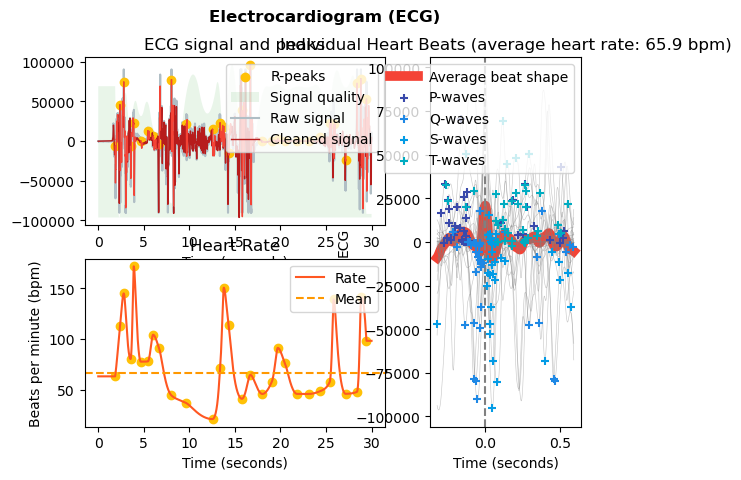

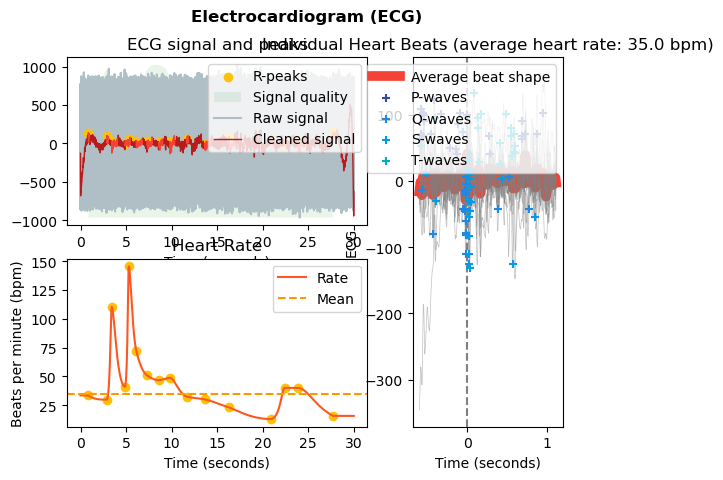

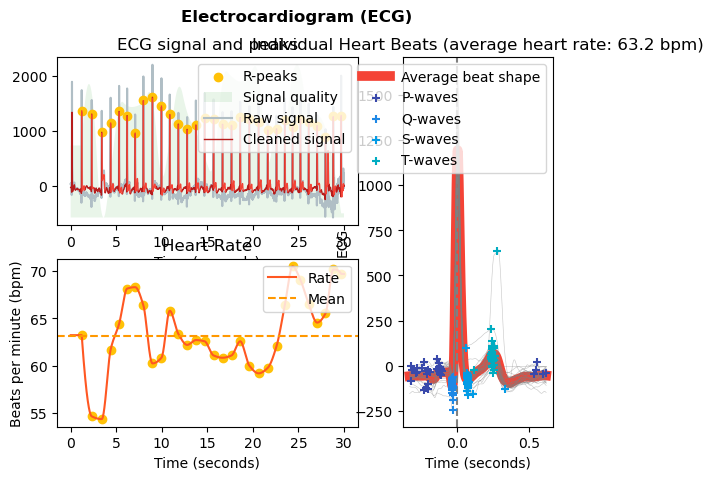

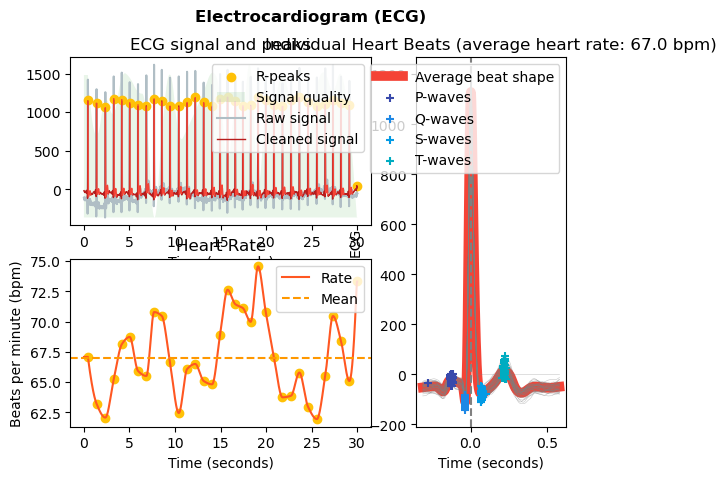

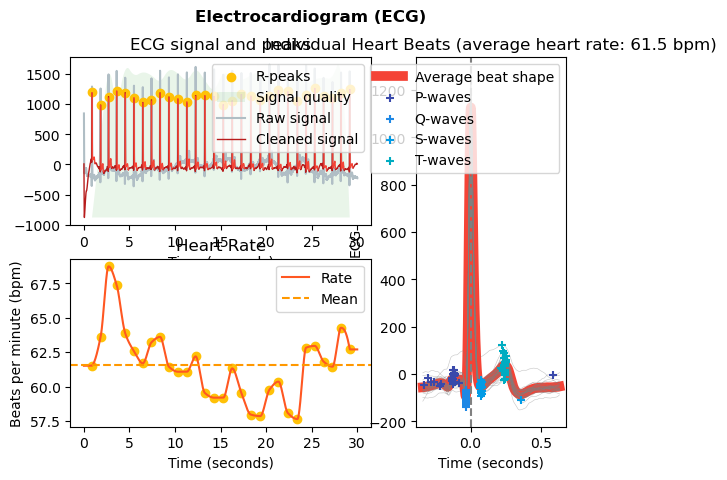

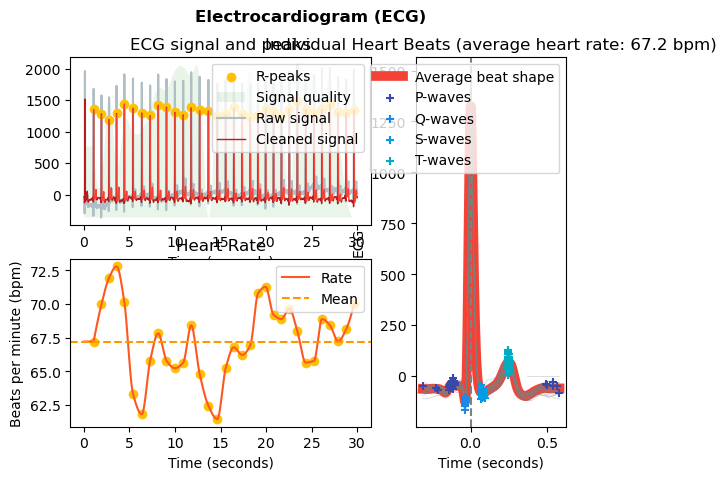

In [7]:
# Process and plot smaller segments from ecg_first_5M at different places

sampling_rate = int(info.get("sampling_rate", 512))
max_seconds = len(ecg_first_5M) / sampling_rate

# Configure window length (seconds) and candidate start times (fractions of the record)
window_sec = 30  # length of each segment to process/plot
candidate_starts = [
    0,
    int(max_seconds * 0.05),
    int(max_seconds * 0.2),
    int(max_seconds * 0.5),
    int(max_seconds * 0.8),
    int(max_seconds * 0.95),
]

# Keep only starts that fit the window inside the available signal
start_times = [s for s in candidate_starts if (s + window_sec) <= max_seconds]

for i, start_sec in enumerate(start_times, 1):
    start_idx = int(start_sec * sampling_rate)
    end_idx = start_idx + int(window_sec * sampling_rate)

    # Extract the segment and reset index so plotting/time axes start at 0 for the segment
    segment = ecg_first_5M.iloc[start_idx:end_idx].reset_index(drop=True)

    print(f"Processing segment {i}: {start_sec}s to {start_sec + window_sec}s "
          f"({len(segment)} samples)")

    # Process and plot this segment
    seg_signals, seg_info = nk.ecg_process(segment, sampling_rate=sampling_rate)
    nk.ecg_plot(seg_signals, seg_info)

In [ ]:
signals.keys()

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')

In [ ]:


# Clean the signal using NeuroKit's clean_ecg function
cleaned_signal = nk.ecg_clean(, sampling_rate=512)

# Assess signal quality using NeuroKit's signal_quality function
signal_quality = nk.ecg_quality(cleaned_signal, sampling_rate=512)

signal_quality_raw = nk.ecg_quality(data[column_name][:2000000], sampling_rate=512)

r_peaks = nk.ecg_findpeaks(cleaned_signal, sampling_rate=512)


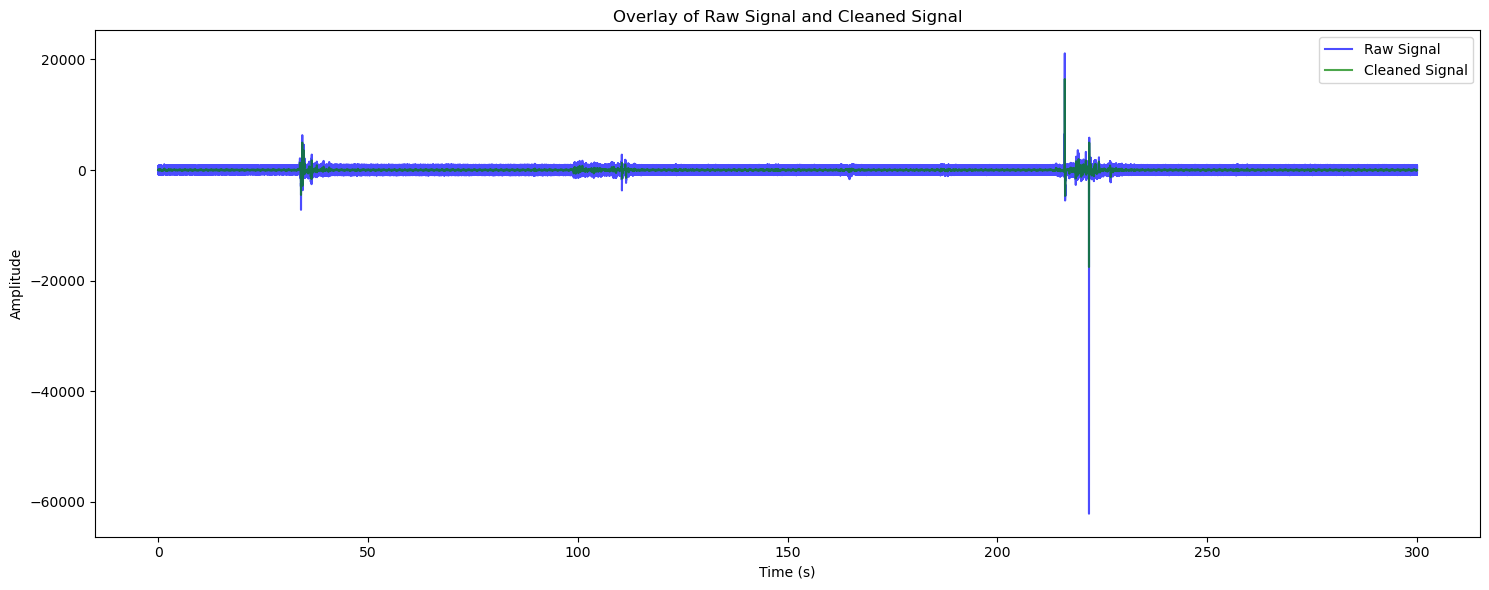

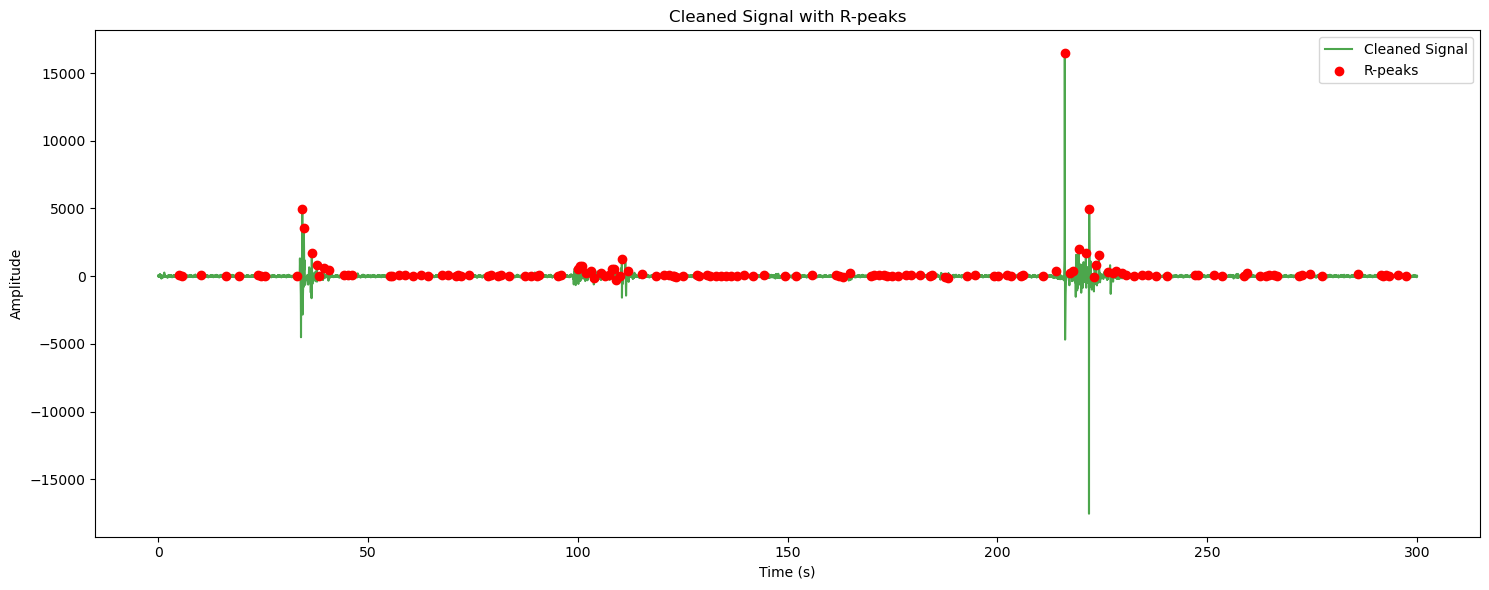

In [18]:
# Define the start time and window length
start_time = 360  # Start at 360 seconds
window_length = 300  # Show 300 seconds of data

# Calculate the start and end indices
start_index = int(start_time * sampling_rate)
end_index = start_index + int(window_length * sampling_rate)

# Adjust the time vector for the selected window
time_window = time[:window_length * sampling_rate]

# Plot the raw signal and cleaned signal as overlays in the same figure
plt.figure(figsize=(15, 6))

# Plot raw signal
plt.plot(time_window, data[column_name][start_index:end_index], label="Raw Signal", color="blue", alpha=0.7)

# Plot cleaned signal
plt.plot(time_window, cleaned_signal[start_index:end_index], label="Cleaned Signal", color="green", alpha=0.7)

# Add titles and labels
plt.title("Overlay of Raw Signal and Cleaned Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

# Plot the R-peaks on top of the cleaned signal
plt.figure(figsize=(15, 6))

# Plot cleaned signal
plt.plot(time_window, cleaned_signal[start_index:end_index], label="Cleaned Signal", color="green", alpha=0.7)

# Extract R-peaks within the selected window
r_peaks_indices = r_peaks['ECG_R_Peaks'][(r_peaks['ECG_R_Peaks'] >= start_index) & (r_peaks['ECG_R_Peaks'] < end_index)]
r_peaks_times = (r_peaks_indices - start_index) / sampling_rate  # Convert indices to time within the window
r_peaks_amplitudes = cleaned_signal[r_peaks_indices]  # Get amplitudes of R-peaks

# Plot R-peaks
plt.scatter(r_peaks_times, r_peaks_amplitudes, color="red", label="R-peaks", zorder=5)

# Add titles and labels
plt.title("Cleaned Signal with R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Count the number of R-peaks within the selected window
num_r_peaks_in_window = len(r_peaks_indices)
print("Number of R-peaks in the shown window:", num_r_peaks_in_window)

Number of R-peaks in the shown window: 150


In [21]:
# Calculate the differences between consecutive R-peak times
r_peaks_differences = np.diff(r_peaks_times)

# Find the minimum and maximum lengths between R-peaks
min_length = np.min(r_peaks_differences)
max_length = np.max(r_peaks_differences)

print("Minimum length between R-peaks in the window:", min_length)
print("Maximum length between R-peaks in the window:", max_length)

Minimum length between R-peaks in the window: 0.37109375
Maximum length between R-peaks in the window: 8.94921875


   /'Untitled'/'EKG'
0         -70.270817
1          -1.377859
2          37.202197
3         -45.469352
4        -144.675212
Column name: /'Untitled'/'EKG'
Antal R-peaks i analysen: 3432
Baseline_std (nan-fri): 3432
Template-korrelation (nan-fri): 3432
      t_start       t_end    t_center  n_beats      amp_mean       amp_std  \
0    1.853516   61.853516   31.853516       47  21167.052190  30951.023139   
1   31.853516   91.853516   61.853516       24  10522.935918  25825.323217   
2   61.853516  121.853516   91.853516       14     29.498285     14.308547   
3   91.853516  151.853516  121.853516       15     36.623543     14.726951   
4  121.853516  181.853516  151.853516       13     37.926247     15.996189   

     amp_cv  prom_mean  prom_median   energy_mean  corr_mean  
0  1.462226   4.864667     2.831022  5.102636e+10   0.588873  
1  2.454194   4.769985     3.172646  2.192375e+10   0.455342  
2  0.485064   2.440051     1.846568  3.511680e+04   0.242202  
3  0.402117   2.308843   

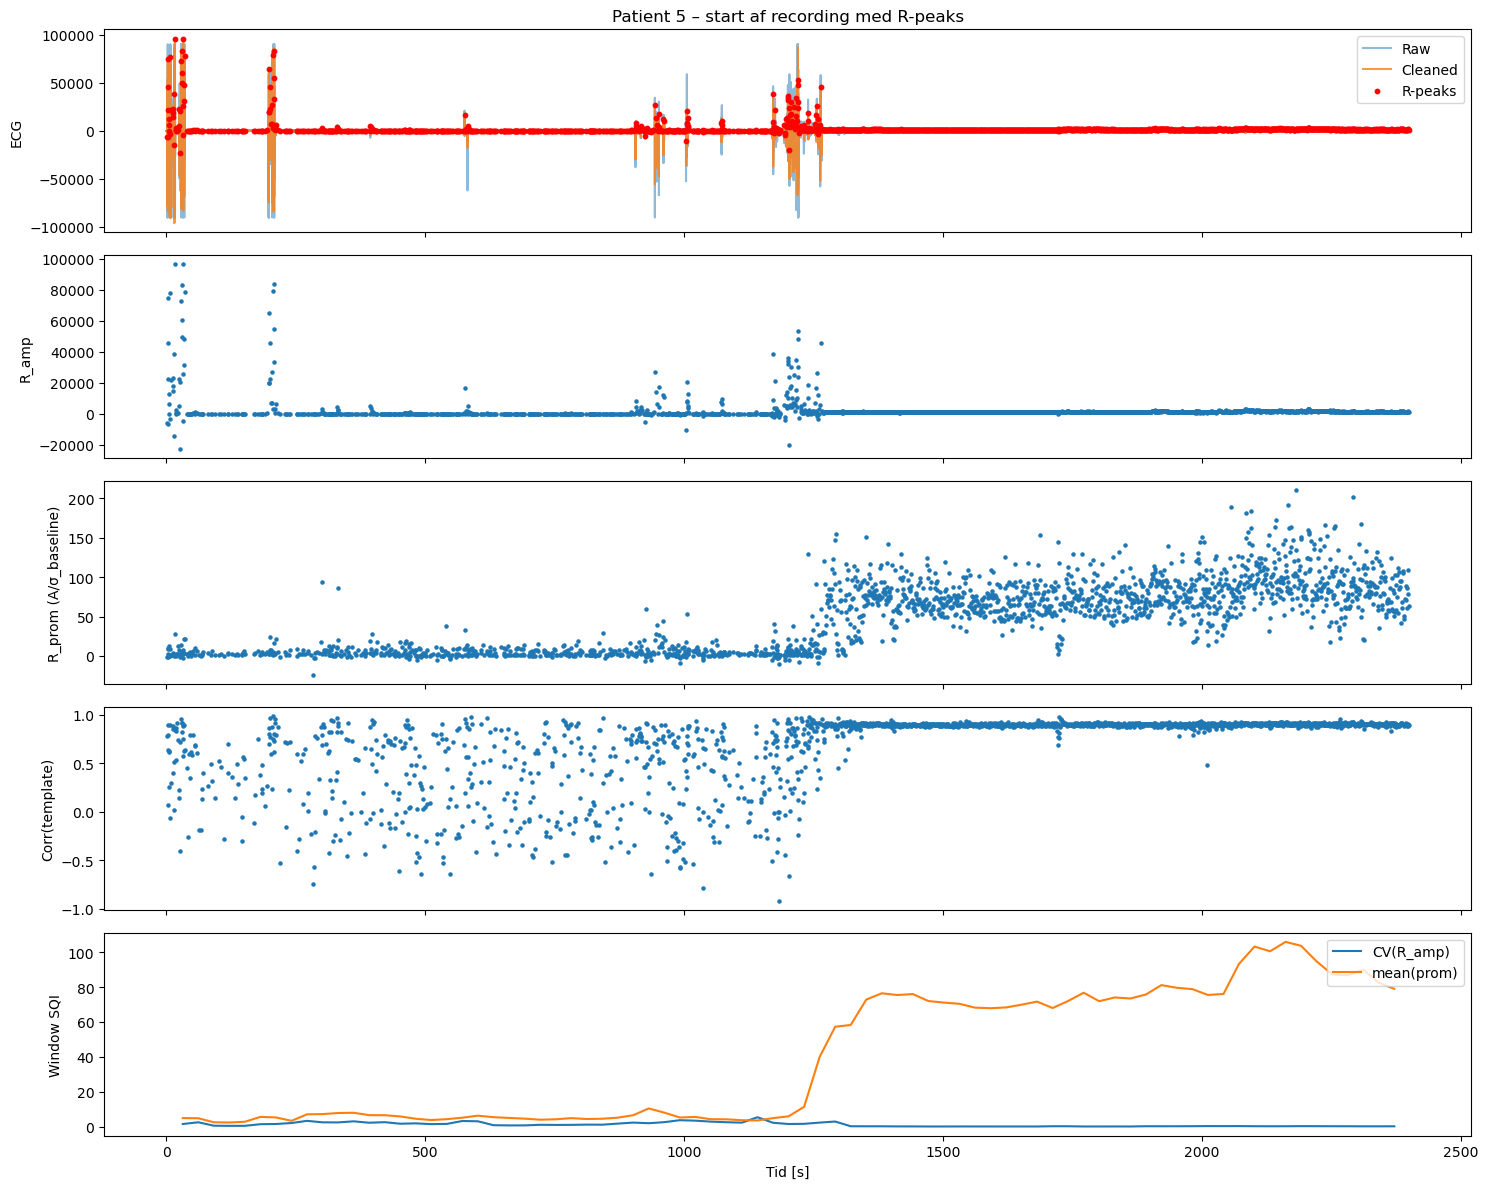

In [8]:
# %% Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
from nptdms import TdmsFile

# %% Paths og konstanter
base_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Croping"

patient_path = (
    r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne"
    r"\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
)

SAMPLING_RATE = 512
MAX_SAMPLES = 2_000_000  # som du allerede brugte

# %% Load TDMS og lav simpel kanal-selektion
tdms_file = TdmsFile.read(patient_path)
data = tdms_file.as_dataframe()
print(data.head())

column_name = data.columns[0]
print("Column name:", column_name)

raw = data[column_name].values[:MAX_SAMPLES]

# tidsakse til plots
time = np.arange(len(raw)) / SAMPLING_RATE

# %% Clean og R-peaks med NeuroKit2
cleaned = nk.ecg_clean(raw, sampling_rate=SAMPLING_RATE)

# NeuroKit finder kun peaks – vi vil gerne have dem som ren array
rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=SAMPLING_RATE)
r_idx = np.array(rpeaks_info["ECG_R_Peaks"], dtype=int)
r_times = r_idx / SAMPLING_RATE
r_amp = cleaned[r_idx]  # amplitude i det rensede signal

print(f"Antal R-peaks i analysen: {len(r_idx)}")


# %% Hjælpefunktioner til SQI-features
def compute_baseline_std(ecg, r_indices, fs, pre_ms=120, exclude_ms=40):
    """Std af baseline før hver R-peak.
    Baseline-vindue: [R - pre_ms, R - exclude_ms]
    """
    pre_samples = int(pre_ms * fs / 1000)
    exclude_samples = int(exclude_ms * fs / 1000)

    baseline_std = np.full(len(r_indices), np.nan, dtype=float)

    for i, r in enumerate(r_indices):
        start = r - pre_samples
        end = r - exclude_samples
        if start < 0 or end <= start:
            continue
        segment = ecg[start:end]
        if len(segment) > 5:
            baseline_std[i] = np.std(segment)
    return baseline_std


def compute_qrs_energy(ecg, r_indices, fs, qrs_half_ms=80):
    """Energi i et QRS-vindue omkring R-peak."""
    half_samples = int(qrs_half_ms * fs / 1000)
    energies = np.full(len(r_indices), np.nan, dtype=float)

    for i, r in enumerate(r_indices):
        start = r - half_samples
        end = r + half_samples
        if start < 0 or end >= len(ecg):
            continue
        segment = ecg[start:end]
        energies[i] = np.sum(segment**2)
    return energies


def build_qrs_template(ecg, r_indices, fs, qrs_half_ms=80, max_beats=500):
    """Byg et template-beat som gennemsnit af QRS-segmenter."""
    half_samples = int(qrs_half_ms * fs / 1000)
    segments = []

    for r in r_indices[:max_beats]:
        start = r - half_samples
        end = r + half_samples
        if start < 0 or end >= len(ecg):
            continue
        seg = ecg[start:end].astype(float)
        seg = seg - np.mean(seg)
        segments.append(seg)

    if len(segments) == 0:
        return None

    segments = np.vstack(segments)
    template = np.mean(segments, axis=0)

    # normaliser template
    norm = np.linalg.norm(template)
    if norm > 0:
        template = template / norm
    return template


def compute_template_correlation(ecg, r_indices, fs, template, qrs_half_ms=80):
    """Korrelation mellem hvert QRS-segment og template."""
    if template is None:
        return np.full(len(r_indices), np.nan, dtype=float)

    half_samples = int(qrs_half_ms * fs / 1000)
    L = len(template)
    corrs = np.full(len(r_indices), np.nan, dtype=float)

    for i, r in enumerate(r_indices):
        start = r - half_samples
        end = r + half_samples
        if start < 0 or end >= len(ecg):
            continue
        seg = ecg[start:end].astype(float)
        if len(seg) != L:
            continue
        seg = seg - np.mean(seg)
        norm = np.linalg.norm(seg)
        if norm == 0:
            continue
        seg = seg / norm
        corrs[i] = np.dot(seg, template)
    return corrs


def aggregate_over_time_windows(
    r_times,
    r_amp,
    prom,
    energy,
    corr,
    window_s=60.0,
    step_s=30.0,
):
    """Aggreger SQI-features i glidende tidsvinduer."""
    if len(r_times) == 0:
        return pd.DataFrame()

    t_min = r_times[0]
    t_max = r_times[-1]

    window_starts = np.arange(t_min, t_max, step_s)
    rows = []

    for ws in window_starts:
        we = ws + window_s
        mask = (r_times >= ws) & (r_times < we)
        if not np.any(mask):
            continue

        amps = r_amp[mask]
        prs = prom[mask]
        ens = energy[mask]
        cors = corr[mask]

        # CV af amplitude
        if np.mean(amps) != 0 and len(amps) > 1:
            cv_r = np.std(amps) / np.mean(amps)
        else:
            cv_r = np.nan

        rows.append(
            dict(
                t_start=ws,
                t_end=we,
                t_center=ws + window_s / 2,
                n_beats=int(np.sum(mask)),
                amp_mean=np.nanmean(amps),
                amp_std=np.nanstd(amps),
                amp_cv=cv_r,
                prom_mean=np.nanmean(prs),
                prom_median=np.nanmedian(prs),
                energy_mean=np.nanmean(ens),
                corr_mean=np.nanmean(cors),
            )
        )

    return pd.DataFrame(rows)


# %% Beregn de nye SQI-features pr. R-peak

baseline_std = compute_baseline_std(
    cleaned, r_idx, SAMPLING_RATE, pre_ms=120, exclude_ms=40
)
r_prom = r_amp / baseline_std  # R-peak prominence ratio
qrs_energy = compute_qrs_energy(cleaned, r_idx, SAMPLING_RATE, qrs_half_ms=80)
template = build_qrs_template(cleaned, r_idx, SAMPLING_RATE, qrs_half_ms=80)
corr_template = compute_template_correlation(
    cleaned, r_idx, SAMPLING_RATE, template, qrs_half_ms=80
)

# Lidt sanity-print
print("Baseline_std (nan-fri):", np.sum(~np.isnan(baseline_std)))
print("Template-korrelation (nan-fri):", np.sum(~np.isnan(corr_template)))


# %% Aggreger pr. tidsvindue (f.eks. 60 s vinduer, 30 s step)
df_win = aggregate_over_time_windows(
    r_times=r_times,
    r_amp=r_amp,
    prom=r_prom,
    energy=qrs_energy,
    corr=corr_template,
    window_s=60.0,
    step_s=30.0,
)

print(df_win.head())
print(f"Antal vinduer: {len(df_win)}")


# %% Plot: oversigt over rå signal + R-peaks + SQI over tid

# Vælg et område i starten af signalet for visualisering (f.eks. de første 40 min)
plot_start_s = 0
plot_end_s = 40 * 60  # 40 min

mask_time = (time >= plot_start_s) & (time <= plot_end_s)

fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

# 1) Rå + cleaned + R-peaks
axes[0].plot(time[mask_time], raw[mask_time], label="Raw", alpha=0.5)
axes[0].plot(time[mask_time], cleaned[mask_time], label="Cleaned", alpha=0.8)

mask_r = (r_times >= plot_start_s) & (r_times <= plot_end_s)
axes[0].scatter(
    r_times[mask_r],
    r_amp[mask_r],
    color="red",
    s=10,
    label="R-peaks",
    zorder=5,
)
axes[0].set_ylabel("ECG")
axes[0].legend(loc="upper right")
axes[0].set_title("Patient 5 – start af recording med R-peaks")

# 2) R-peak amplitude
axes[1].scatter(r_times[mask_r], r_amp[mask_r], s=5)
axes[1].set_ylabel("R_amp")

# 3) Prominence ratio
axes[2].scatter(r_times[mask_r], r_prom[mask_r], s=5)
axes[2].set_ylabel("R_prom (A/σ_baseline)")

# 4) Template-korrelation
axes[3].scatter(r_times[mask_r], corr_template[mask_r], s=5)
axes[3].set_ylabel("Corr(template)")

# 5) Vindue-aggregat (amp_cv og prom_mean f.eks.)
mask_win = (df_win["t_center"] >= plot_start_s) & (
    df_win["t_center"] <= plot_end_s
)
axes[4].plot(
    df_win.loc[mask_win, "t_center"],
    df_win.loc[mask_win, "amp_cv"],
    label="CV(R_amp)",
)
axes[4].plot(
    df_win.loc[mask_win, "t_center"],
    df_win.loc[mask_win, "prom_mean"],
    label="mean(prom)",
)
axes[4].set_ylabel("Window SQI")
axes[4].set_xlabel("Tid [s]")
axes[4].legend(loc="upper right")

plt.tight_layout()
plt.show()
